In [193]:
%load_ext autoreload
%autoreload 2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob

import sys
sys.path.append('../python')
from functions import *
from models import *

import tensorflow as tf
from livelossplot import PlotLossesKeras
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# One patch

### Load a file and label the stream stars

In [ ]:
df = load_file()

In [ ]:
make_plots(df)

In [ ]:
plt.figure(dpi=150)
plt.scatter(df[df.stream]['α_wrapped']-360, df[df.stream]['δ'], marker='.')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\delta$")
plt.title("GD1 Stars");
plt.xlim(-241,-135);
plt.ylim(-10,65);

# All patches

In [248]:
patch_list = [
 # b = 33.7 
 '../gaia_data/gd1/gaiascan_l195.0_b33.7_ra128.4_dec28.8.npy',
 '../gaia_data/gd1/gaiascan_l210.0_b33.7_ra132.6_dec16.9.npy',
 '../gaia_data/gd1/gaiascan_l225.0_b33.7_ra138.1_dec5.7.npy', 
 # b = 41.8 
 '../gaia_data/gd1/gaiascan_l187.5_b41.8_ra136.5_dec36.1.npy',
 '../gaia_data/gd1/gaiascan_l202.5_b41.8_ra138.8_dec25.1.npy',
 '../gaia_data/gd1/gaiascan_l217.5_b41.8_ra142.7_dec14.5.npy', 
 # b = 50.2 
 '../gaia_data/gd1/gaiascan_l99.0_b50.2_ra224.7_dec60.6.npy',
 '../gaia_data/gd1/gaiascan_l117.0_b50.2_ra202.4_dec66.5.npy',
 '../gaia_data/gd1/gaiascan_l135.0_b50.2_ra174.3_dec65.1.npy',
 '../gaia_data/gd1/gaiascan_l153.0_b50.2_ra156.2_dec57.5.npy',
 '../gaia_data/gd1/gaiascan_l171.0_b50.2_ra148.6_dec47.0.npy',
 '../gaia_data/gd1/gaiascan_l189.0_b50.2_ra146.9_dec35.6.npy',
 '../gaia_data/gd1/gaiascan_l207.0_b50.2_ra148.6_dec24.2.npy',
 # b = 58.4 
 '../gaia_data/gd1/gaiascan_l101.2_b58.4_ra212.7_dec55.2.npy',
 '../gaia_data/gd1/gaiascan_l123.8_b58.4_ra192.0_dec58.7.npy',
 '../gaia_data/gd1/gaiascan_l146.2_b58.4_ra171.8_dec54.7.npy',
 '../gaia_data/gd1/gaiascan_l168.8_b58.4_ra160.5_dec45.5.npy',
 '../gaia_data/gd1/gaiascan_l191.2_b58.4_ra156.9_dec34.1.npy',
 # b = 66.4 
 '../gaia_data/gd1/gaiascan_l105.0_b66.4_ra203.7_dec49.1.npy',
 '../gaia_data/gd1/gaiascan_l135.0_b66.4_ra185.4_dec50.0.npy',
 '../gaia_data/gd1/gaiascan_l165.0_b66.4_ra171.4_dec43.0.npy',    
]

In [249]:
# ### Slow -- make the dataframes (better in a separate screen, tbh) 
# for file in tqdm(patch_list):
#     df = load_file(file)
#     df["patch_id"] = patch_list.index(file)
#     df.to_hdf(file[:-4]+".h5", "df")

In [250]:
### Fast -- load the dataframes & concatenate 
dfs = []
for file in tqdm(patch_list):
    df = pd.read_hdf(file[:-4]+".h5")
    dfs.append(df)
df_all = pd.concat(dfs)

100%|██████████| 21/21 [00:04<00:00,  4.53it/s]


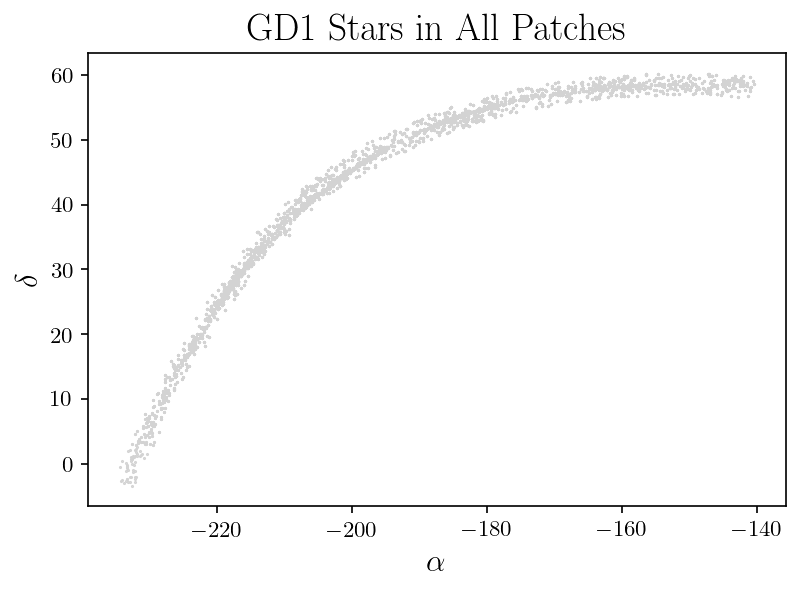

In [251]:
plt.figure(dpi=150)
plt.scatter(df_all[df_all.stream]['α_wrapped'] - 360, df_all[df_all.stream]['δ'], marker='.', color='lightgray', s=1)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\delta$")
plt.title("GD1 Stars in All Patches");

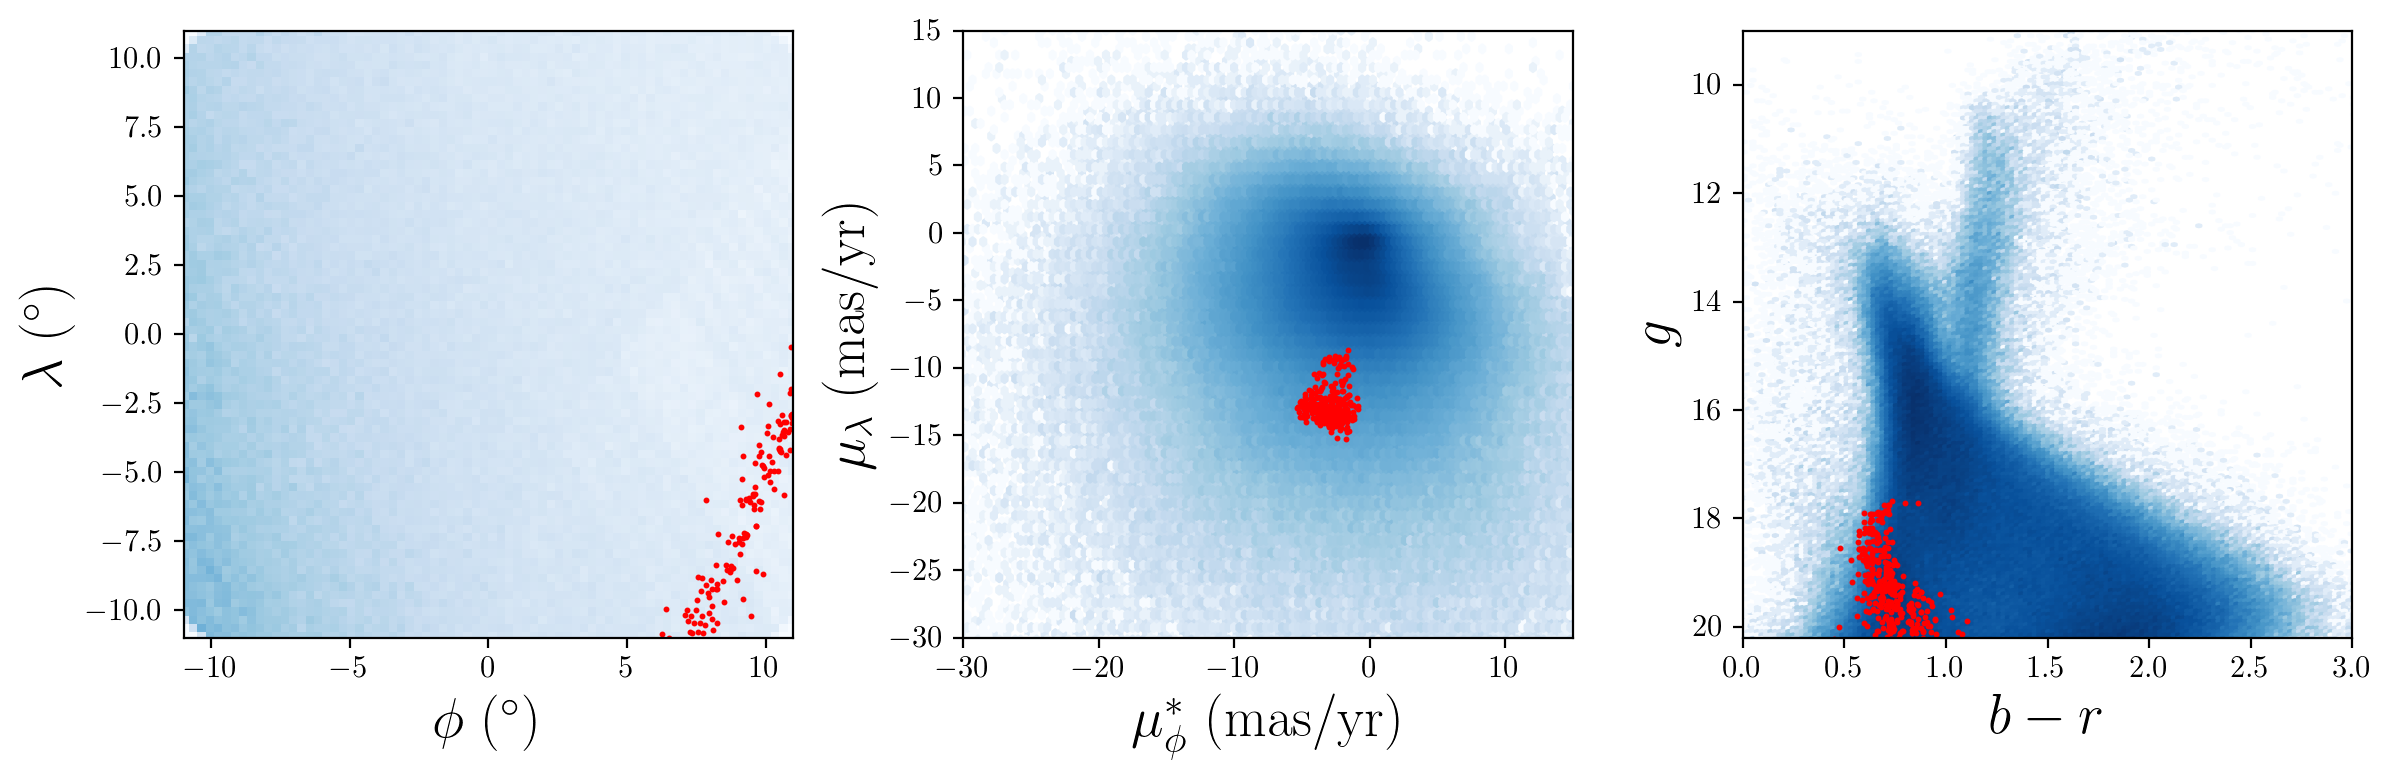

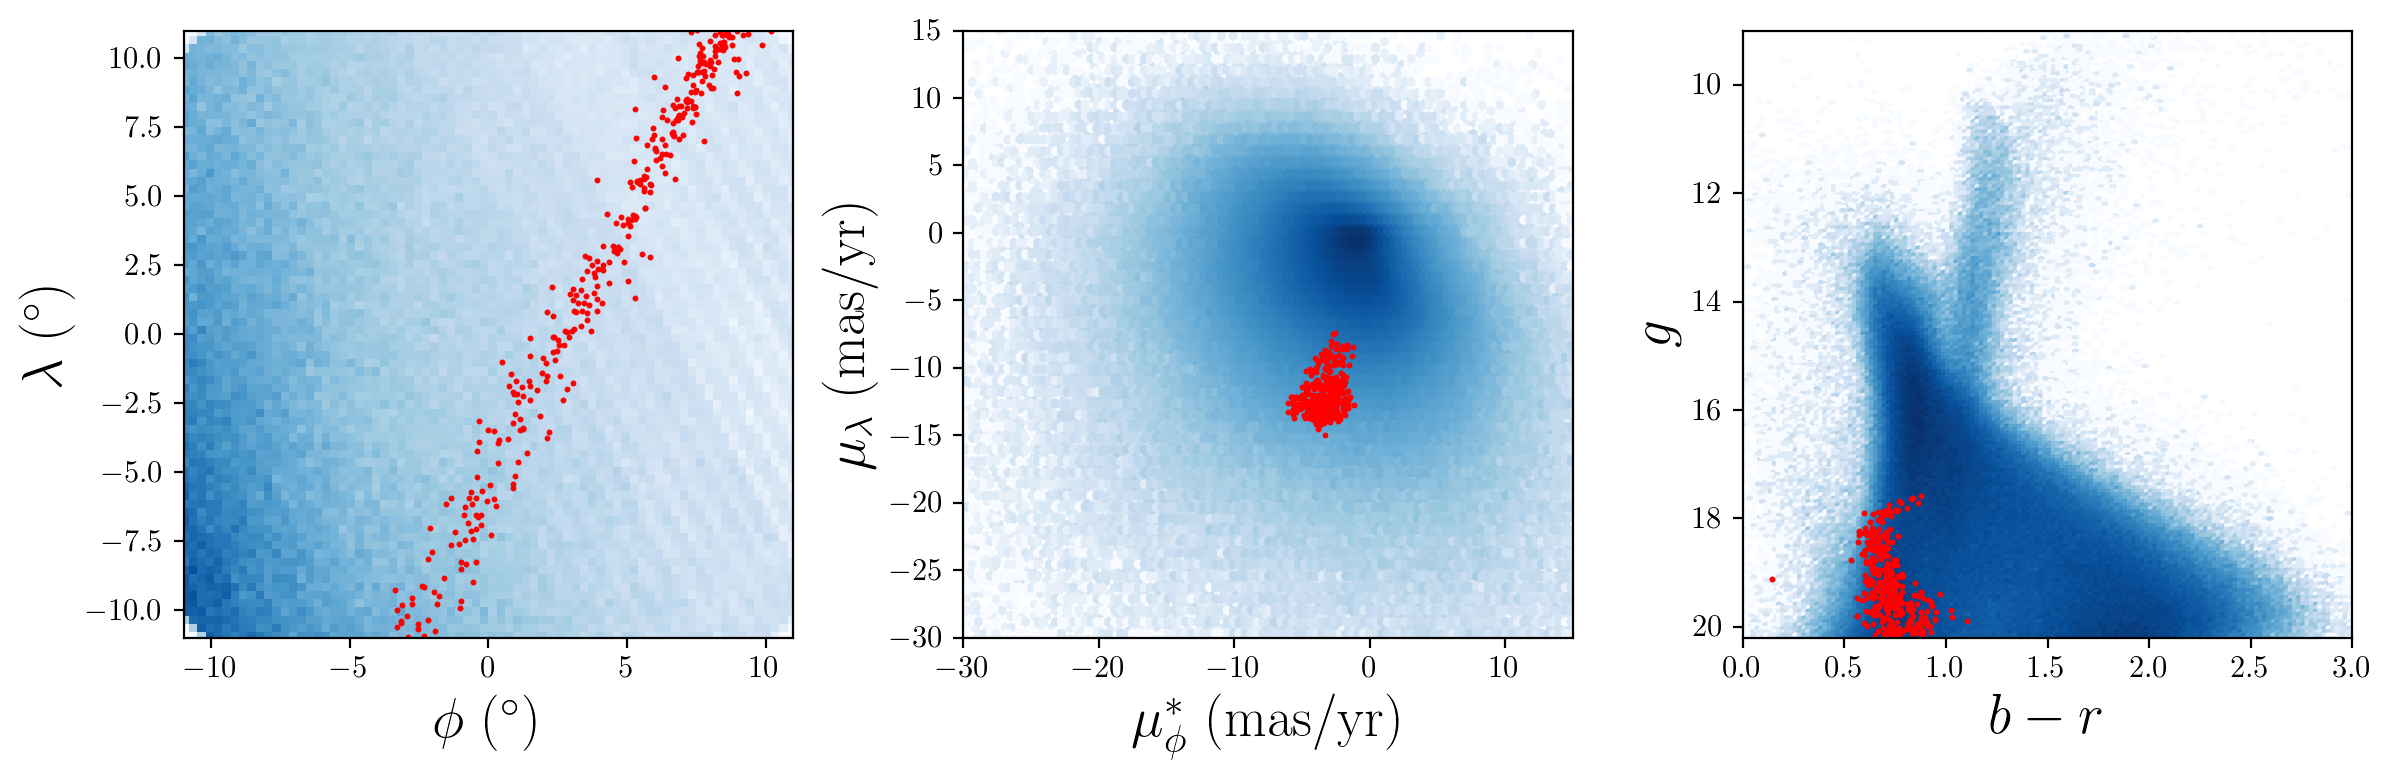

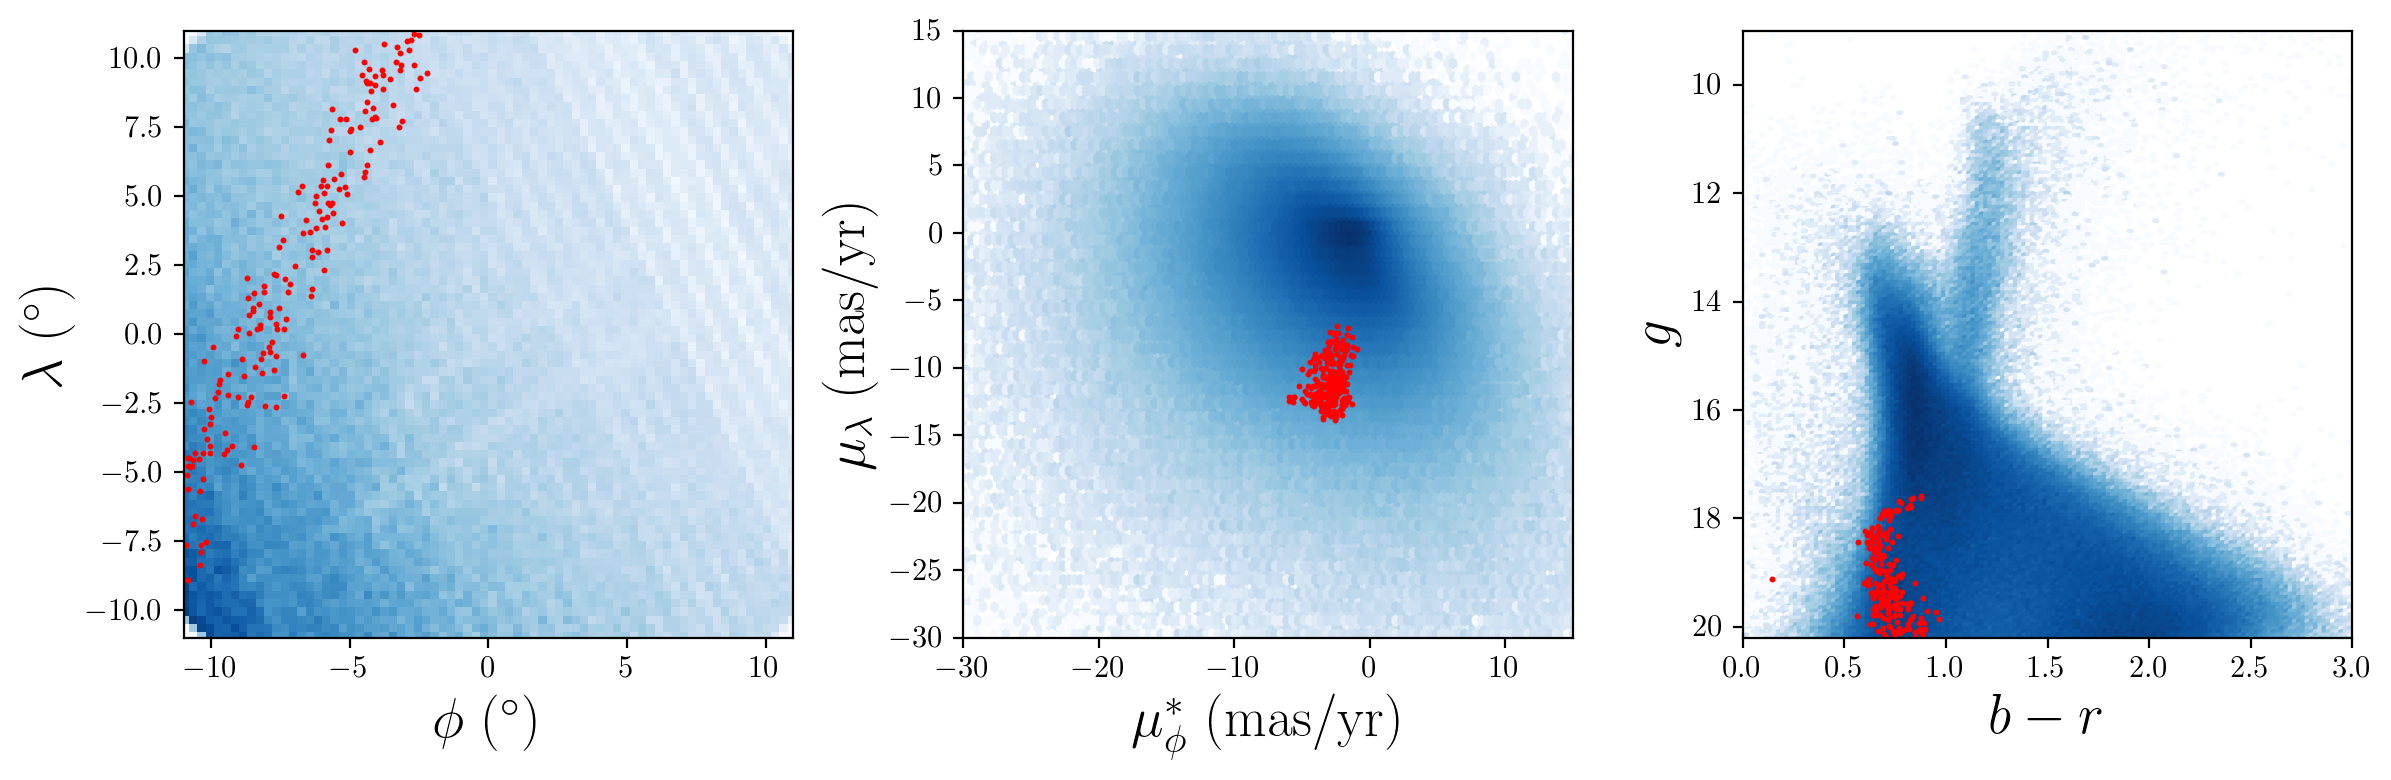

In [6]:
for patch_id in [0,1,2]: #df_all.patch_id.unique(): 
    df = df_all[df_all.patch_id == patch_id]
    
    fig = plt.figure(figsize=(12,4), dpi=200, tight_layout=True)
    ax = fig.add_subplot(131)
    ax.hist2d(df['ϕ'], df['λ'], bins=100, cmap="Blues");
    ax.scatter(df[df.stream]['ϕ'], df[df.stream]['λ'], marker='.', s=5, color='red')
    ax.set_xlabel(r'$\phi~(^\circ)$',fontsize=20)
    ax.set_ylabel(r'$\lambda~(^\circ)$',fontsize=20)
    ax.set_xlim(-11,11);
    ax.set_ylim(-11,11);

    ax = fig.add_subplot(132)
    ax.hexbin(df['μ_ϕcosλ'], df['μ_λ'], cmap='Blues', bins='log', gridsize=400, mincnt=1)
    ax.scatter(df[df.stream]['μ_ϕcosλ'], df[df.stream]['μ_λ'], marker='.', s=5, color='red')
    ax.set_xlim(-30,15)
    ax.set_ylim(-30,15)
    ax.set_xlabel(r'$\mu_\phi^*$ (mas/yr)',fontsize=20)
    ax.set_ylabel(r'$\mu_\lambda$ (mas/yr)',fontsize=20)

    ax = fig.add_subplot(133)
    ax.hexbin(df['b-r'], df['g'], cmap='Blues', bins='log', gridsize=400, mincnt=1)
    ax.scatter(df[df.stream]['b-r'], df[df.stream]['g'], marker='.', s=5, color='red')
    ax.set_xlabel(r'$b-r$',fontsize=20)
    ax.set_ylabel(r'$g$',fontsize=20)
    ax.set_xlim(0,3)
    ax.set_ylim(9,20.2)
    ax.invert_yaxis() 

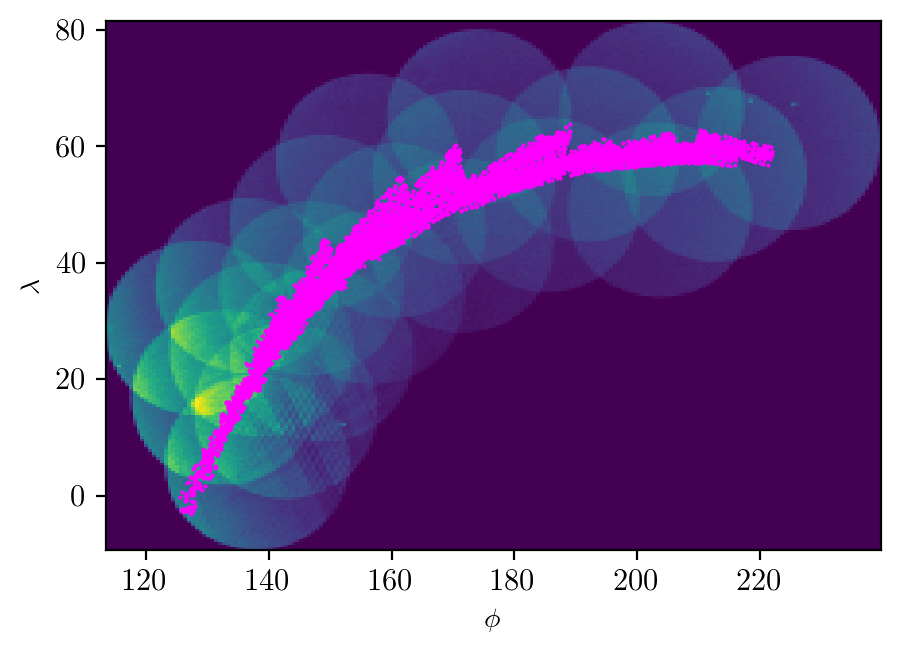

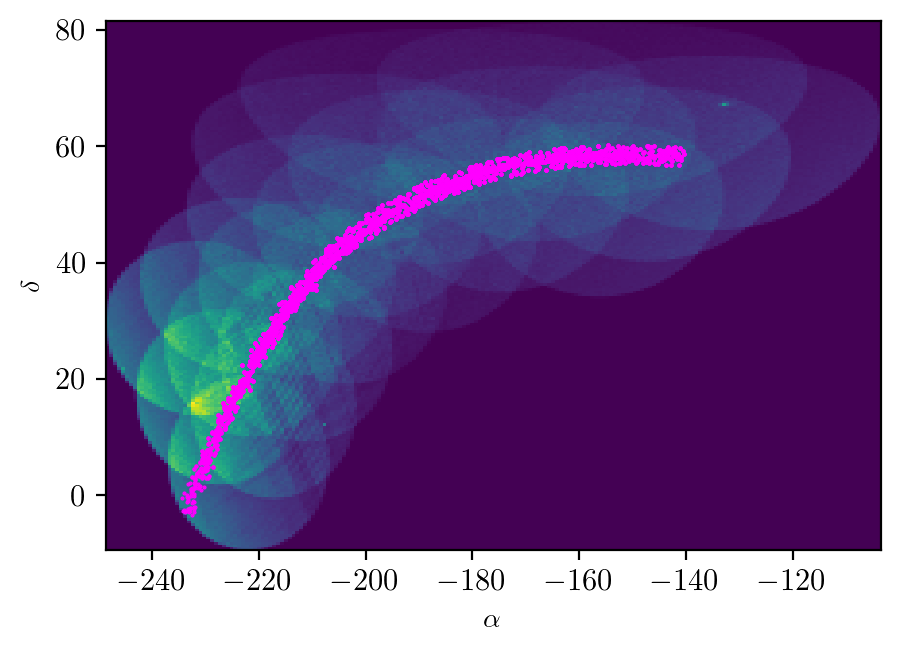

In [18]:
### α0 and δ0 offsets of each patch 

offsets = {
    "patch_0" : (128.4, 28.8),
    "patch_1" : (132.6, 16.9),
    "patch_2" : (138.1, 5.7),
    "patch_3" : (136.5, 36.1),
    "patch_4" : (138.8, 25.1),
    "patch_5" : (142.7, 14.5),
    "patch_6" : (224.7, 60.6),
    "patch_7" : (202.4, 66.5),
    "patch_8" : (174.3, 65.1),
    "patch_9" : (156.2, 57.5),
    "patch_10" : (148.6, 47.0),
    "patch_11" : (146.9, 35.6),
    "patch_12" : (148.6, 24.2),
    "patch_13" : (212.7, 55.2),
    "patch_14" : (192.0, 58.7),
    "patch_15" : (171.8, 54.7),
    "patch_16" : (160.5, 45.5),
    "patch_17" : (156.9, 34.1),
    "patch_18" : (203.7, 49.1),
    "patch_19" : (185.4, 50.0),
    "patch_20" : (171.4, 43.0),
          }

patches = []
for patch_id in range(21): 
    patch = df_all[df_all.patch_id == patch_id]
    patch['ϕ_absolute'] = patch['ϕ'] + offsets['patch_'+str(patch_id)][0]
    patch['λ_absolute'] = patch['λ'] + offsets['patch_'+str(patch_id)][1]
    patches.append(patch)
df = pd.concat(patches)

plt.figure(dpi=200, figsize=(5,3.5))
plt.hist2d(df['ϕ_absolute'], df['λ_absolute'], bins=200);
plt.scatter(df[df.stream]['ϕ_absolute'], df[df.stream]['λ_absolute'], color="magenta", marker='.', s=1)
plt.xlabel(r'$\phi$');
plt.ylabel(r'$\lambda$');

plt.figure(dpi=200, figsize=(5,3.5))
plt.hist2d(df['α_wrapped'] - 360, df['δ'], bins=200);
plt.scatter(df[df.stream]['α_wrapped'] - 360, df[df.stream]['δ'], color="magenta", marker='.', s=1)
plt.xlabel(r'$\alpha$');
plt.ylabel(r'$\delta$');

## Megapatch

In [271]:
### Fast -- load the dataframes & concatenate 
dfs = []
for file in tqdm(patch_list):
    df = pd.read_hdf(file[:-4]+".h5")
    dfs.append(df)
df_all = pd.concat(dfs)

100%|██████████| 21/21 [00:04<00:00,  4.27it/s]


In [272]:
df_all.reset_index(inplace=True)
df_all.drop_duplicates(subset = 'index')
df_all.drop_duplicates(subset=['α','δ', 'μ_α', 'μ_δ', 'b-r', 'g'], inplace=True)

In [273]:
df_all.shape

(9382091, 14)

In [274]:
np.sum(df_all.stream)

1958

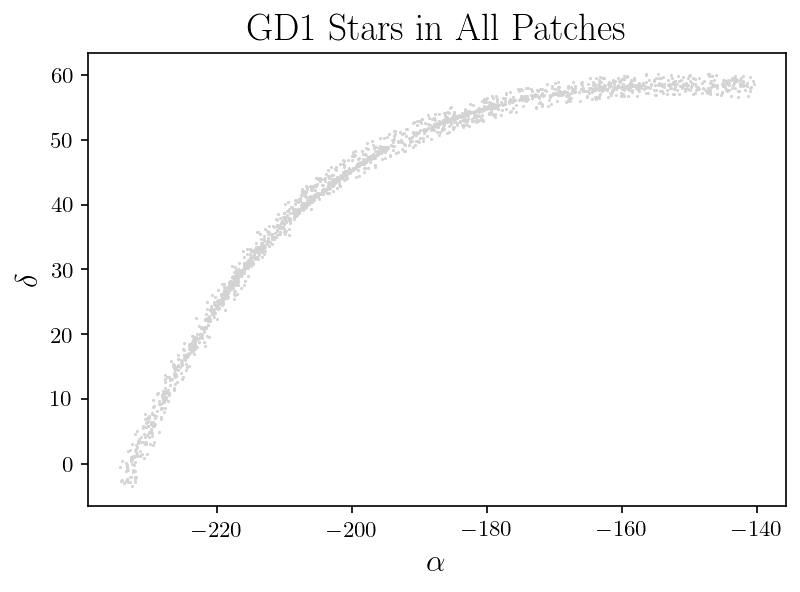

In [275]:
plt.figure(dpi=150)
plt.scatter(df_all[df_all.stream]['α_wrapped'] - 360, df_all[df_all.stream]['δ'], marker='.', color='lightgray', s=1)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\delta$")
plt.title("GD1 Stars in All Patches");

In [302]:
df_cuts = df_all[(df_all.g < 20.2) & (0.5 <= df_all['b-r']) & (df_all['b-r'] <= 1)]

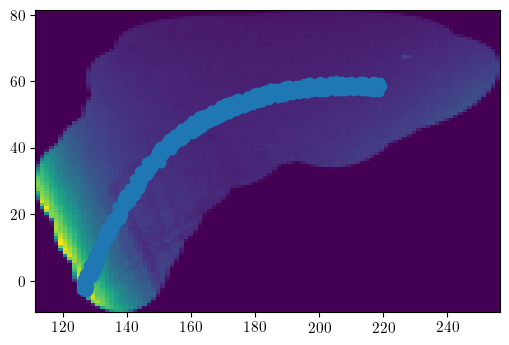

In [327]:
plt.hist2d(df_all.α_wrapped, df_all.δ, bins=100);
plt.scatter(df_all[df_all.stream].α_wrapped, df_all[df_all.stream].δ)

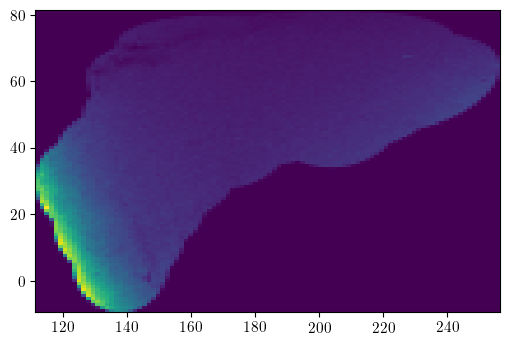

In [303]:
plt.hist2d(df_cuts.α_wrapped, df_cuts.δ, bins=100);

In [324]:
coord_icrs = SkyCoord(
                ra=(df_cuts[((df_cuts.patch_id == 0) & df.stream)]['α_wrapped'] - 360)*u.degree, 
                dec=df_cuts[((df_cuts.patch_id == 0) & df.stream)].δ*u.degree, frame='icrs')

/tmp/ipykernel_7160/562005563.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ra=(df_cuts[((df_cuts.patch_id == 0) & df.stream)]['α_wrapped'] - 360)*u.degree,
/tmp/ipykernel_7160/562005563.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dec=df_cuts[((df_cuts.patch_id == 0) & df.stream)].δ*u.degree, frame='icrs')


In [325]:
coord_gd1 = coord_icrs.transform_to(gd1_frame)
stream_phi1 = coord_gd1.phi1.degree
stream_phi2 = coord_gd1.phi2.degree

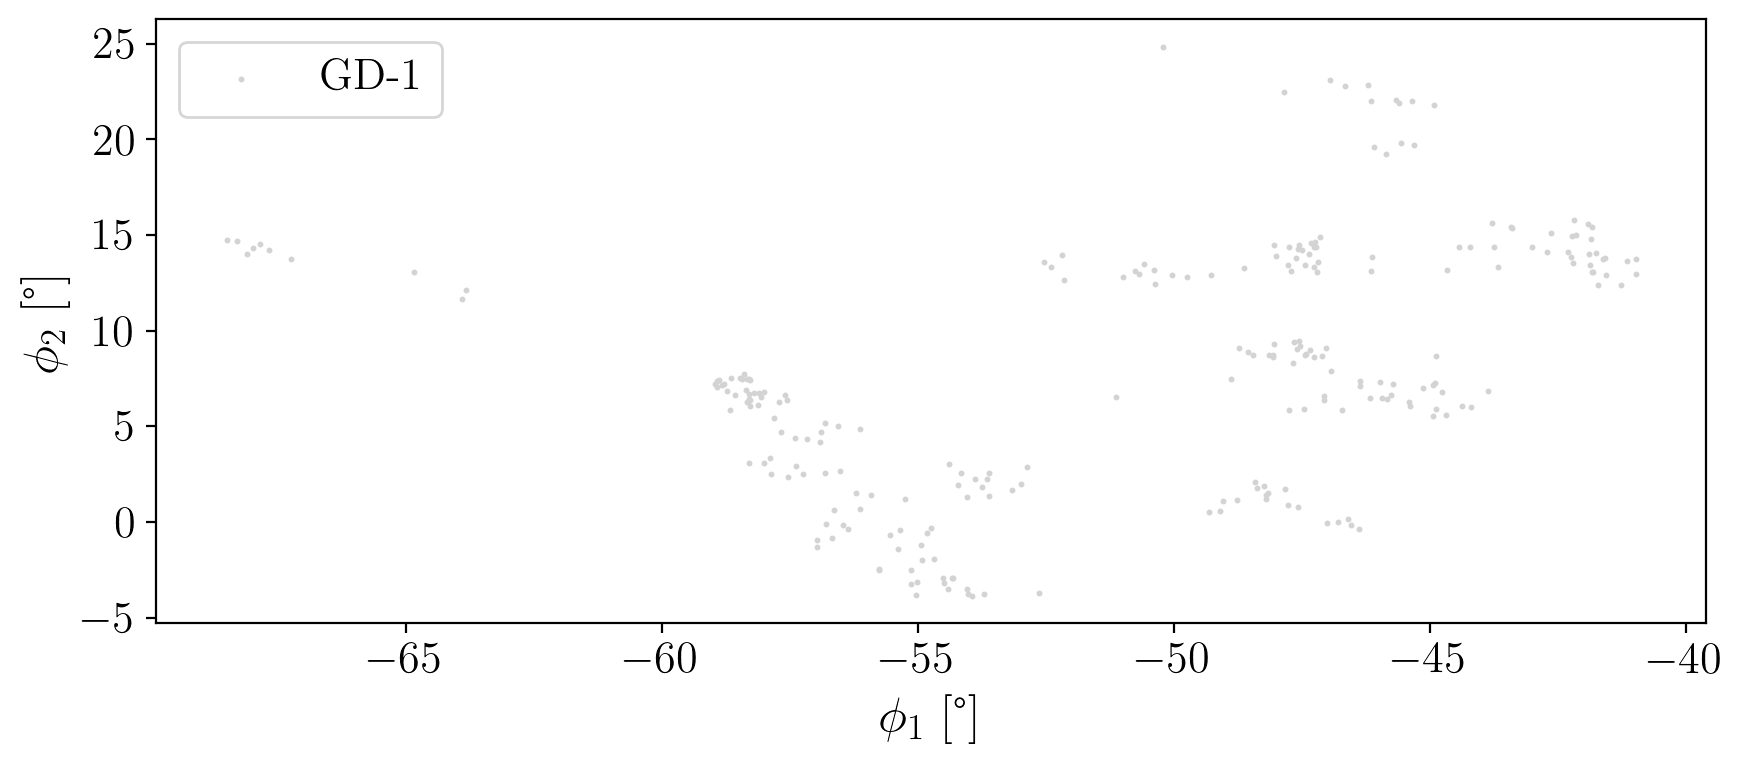

In [326]:
markersize = 5
plt.figure(dpi=200, figsize=(10,4))
plt.scatter(stream_phi1, stream_phi2, 
            marker='.', s=markersize, color="lightgray", label="GD-1")
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r"$\phi_1$ [\textdegree]", fontsize=18);
plt.ylabel(r"$\phi_2$ [\textdegree]", fontsize=18);

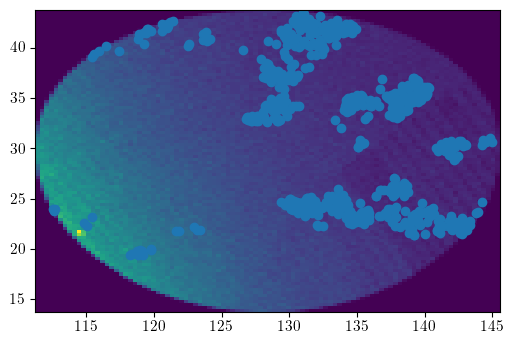

In [332]:
plt.hist2d(df_all[df_all.patch_id==0].α_wrapped, 
           df_all[df_all.patch_id==0].δ, bins=100);
plt.scatter(df_all[(df_all.patch_id==0) & df.stream].α_wrapped, 
            df_all[(df_all.patch_id==0) & df.stream].δ);

In [296]:
import astropy.units as u
from gala.coordinates import GD1Koposov10
from astropy.coordinates import SkyCoord

gd1_frame = GD1Koposov10()

### All GD-1 stars
SkyCoord(ra=(df_all[df_all.stream]['α_wrapped'] - 360)*u.degree, 
         dec=df_all[df_all.stream].δ*u.degree, frame='icrs')
# coord_gd1 = coord_icrs.transform_to(gd1_frame)
# df_all['ϕ1'] = coord_gd1.phi1.degree
# df_all['ϕ2'] = coord_gd1.phi2.degree

<SkyCoord (ICRS): (ra, dec) in deg
    [(137.23742676, 18.7428627 ), (136.76300049, 18.62766075),
     (136.1647644 , 18.50567627), ..., (155.56750488, 41.92628098),
     (154.4395752 , 42.30558395), (154.4994812 , 41.66984177)]>

# Remake Via Machinae plot from test dataframes saved during the training

33.333333333333336
38.0
86.0
90.0
90.0
0.0
skipping ../trained_models/new_sr1_sb3_gpu/patches/patch13/df_test.h5
70.0
66.0
82.0
88.0
0.0
skipping ../trained_models/new_sr1_sb3_gpu/patches/patch18/df_test.h5
56.0
0.0
skipping ../trained_models/new_sr1_sb3_gpu/patches/patch2/df_test.h5
68.0
92.0
90.0
46.0
0.0
skipping ../trained_models/new_sr1_sb3_gpu/patches/patch6/df_test.h5
50.0
30.0
8.823529411764707

1,450 true GD-1 stars pass fiducial cuts.
890 stars identified by CWoLa, of which 531 belong to GD-1.

Purity = 60% in top CWoLa-identified stars
Completeness = 37% vs. all of GD-1


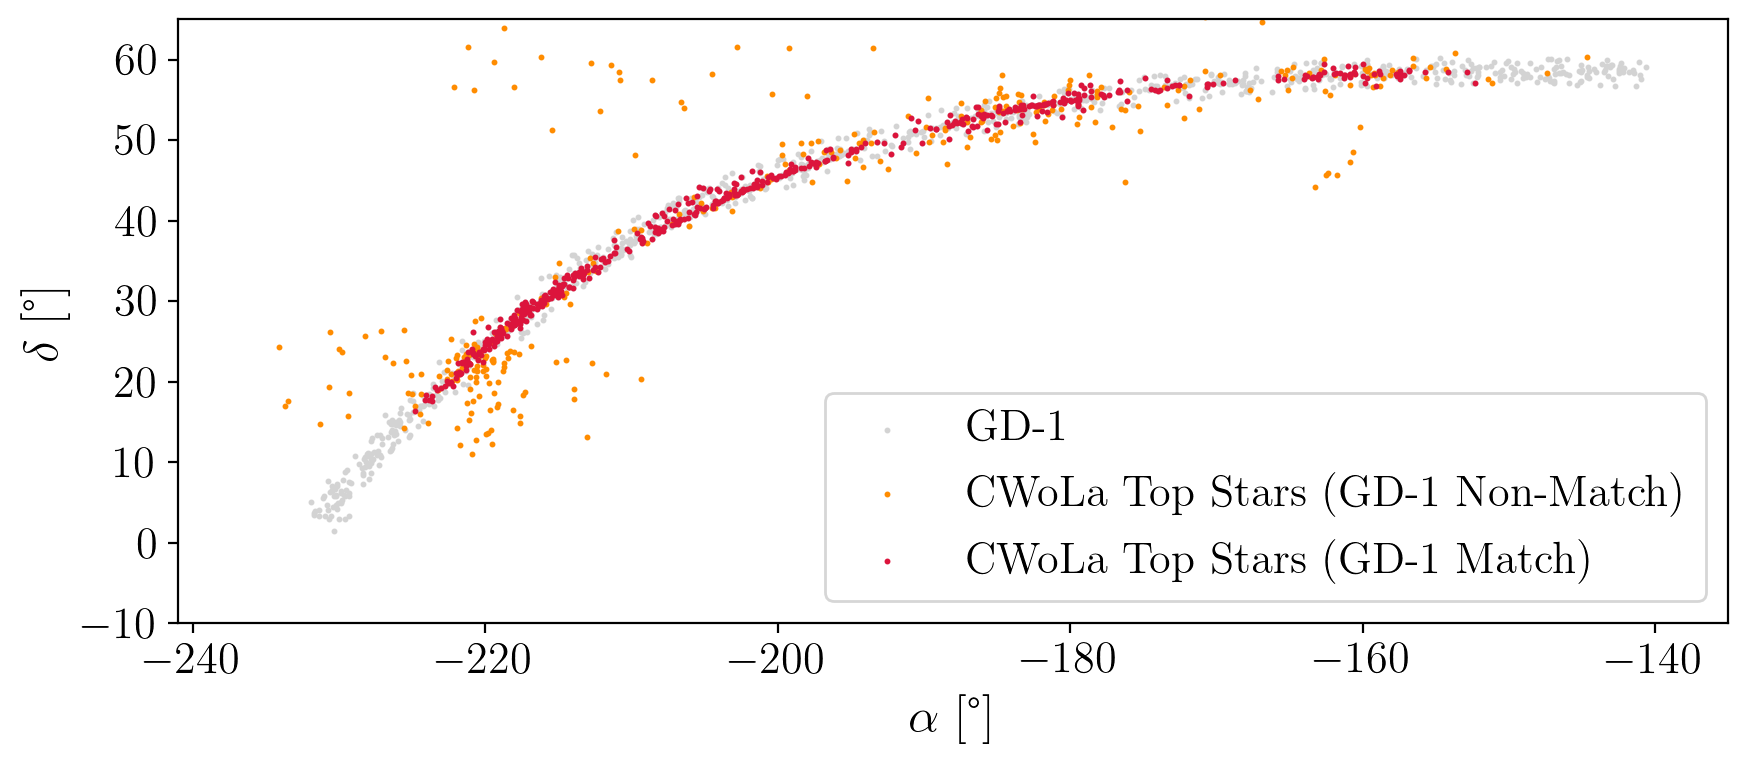

In [338]:
all_gd1_stars = []
cwola_stars = []

files = sorted(glob("../trained_models/new_sr1_sb3_gpu/patches/patch*/df_test.h5"))

for file in files: # use all files to create stream stars
    test = pd.read_hdf(file)
    test = fiducial_cuts(test)
    all_gd1_stars.append(test[test.stream])    

for file in files:
    test = pd.read_hdf(file)
    test = fiducial_cuts(test)
    n_top_stars = np.min([len(test[test.stream]),100])
    patch_top_stars = test.sort_values('nn_score',ascending=False)[:n_top_stars]
    purity = 100*len(patch_top_stars[patch_top_stars.stream])/len(patch_top_stars)
    print(purity)
    if purity < 1:
        print("skipping "+str(file))
        continue
    else:
        cwola_stars.append(patch_top_stars)
    
all_gd1_stars = pd.concat([df for df in all_gd1_stars])
cwola_stars = pd.concat([df for df in cwola_stars])

all_gd1_stars.reset_index(inplace=True)
all_gd1_stars.drop_duplicates(subset = 'index')
all_gd1_stars.drop_duplicates(subset=['α','δ', 'μ_α', 'μ_δ', 'b-r', 'g'], inplace=True)

cwola_stars.reset_index(inplace=True)
cwola_stars.drop_duplicates(subset = 'index')
cwola_stars.drop_duplicates(subset=['α','δ', 'μ_α', 'μ_δ', 'b-r', 'g'], inplace=True)

all_gd1_stars['α'] = all_gd1_stars['α']-360
cwola_stars['α'] = cwola_stars['α']-360

markersize = 5
plt.figure(dpi=200, figsize=(10,4))
plt.scatter(all_gd1_stars.α_wrapped - 360, all_gd1_stars.δ, marker='.', s=markersize, 
            color="lightgray", label="GD-1")
plt.scatter(cwola_stars[cwola_stars.stream == False].α_wrapped - 360, cwola_stars[cwola_stars.stream == False].δ, marker='.', s=markersize, 
            color="darkorange", label="CWoLa Top Stars (GD-1 Non-Match)")
plt.scatter(cwola_stars[cwola_stars.stream].α_wrapped - 360, cwola_stars[cwola_stars.stream].δ, marker='.', s=markersize, 
            color="crimson", label="CWoLa Top Stars (GD-1 Match)")
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r"$\alpha$ [\textdegree]", fontsize=18);
plt.ylabel(r"$\delta$ [\textdegree]", fontsize=18);
# plt.xlim(120,220);
plt.xlim(-241,-135);
plt.ylim(-10,65);
# plt.savefig("via_machinae_aps_50patches_top50.pdf", bbox_inches="tight");

print("\n{:,} true GD-1 stars pass fiducial cuts.".format(all_gd1_stars.shape[0]))
print("{:,} stars identified by CWoLa, of which {:,} belong to GD-1.".format(cwola_stars.shape[0], len(cwola_stars[cwola_stars.stream])))

print("\nPurity = {:.0f}% in top CWoLa-identified stars".format(100*len(cwola_stars[cwola_stars.stream])/len(cwola_stars)))
print("Completeness = {:.0f}% vs. all of GD-1".format(100*len(cwola_stars[cwola_stars.stream])/len(all_gd1_stars)))

## Add μ_ϕ stars

33.333333333333336
0.0
skipping ../trained_models/scan_over_mu_phi/patches/patch1/df_test.h5
89.0
95.0
91.0
0.0
skipping ../trained_models/scan_over_mu_phi/patches/patch13/df_test.h5
0.0
skipping ../trained_models/scan_over_mu_phi/patches/patch14/df_test.h5
58.0
93.0
88.0
0.0
skipping ../trained_models/scan_over_mu_phi/patches/patch18/df_test.h5
21.0
0.0
skipping ../trained_models/scan_over_mu_phi/patches/patch2/df_test.h5
86.0
90.0
92.0
0.0
skipping ../trained_models/scan_over_mu_phi/patches/patch5/df_test.h5
0.0
skipping ../trained_models/scan_over_mu_phi/patches/patch6/df_test.h5
0.0
skipping ../trained_models/scan_over_mu_phi/patches/patch7/df_test.h5
10.0
41.1764705882353

1,450 true GD-1 stars pass fiducial cuts.
602 stars identified by CWoLa, of which 393 belong to GD-1.

Purity = 65% in top CWoLa-identified stars
Completeness = 27% vs. all of GD-1


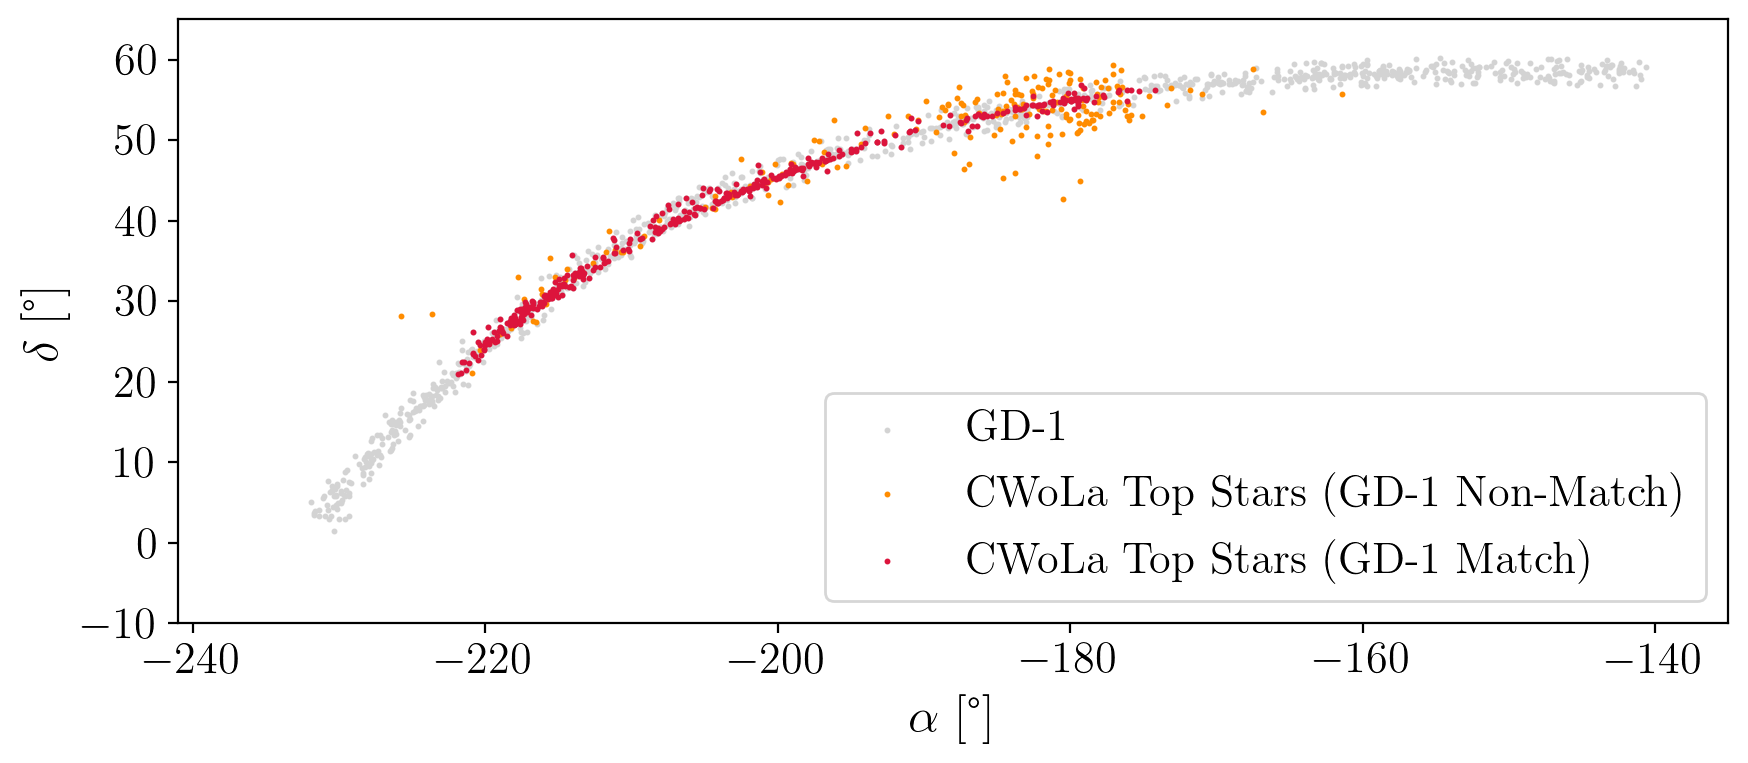

In [341]:
# all_gd1_stars = []
cwola_stars_mu_phi = []

files = sorted(glob("../trained_models/scan_over_mu_phi/patches/patch*/df_test.h5"))

# for file in files: # use all files to create stream stars
#     test = pd.read_hdf(file)
#     test = fiducial_cuts(test)
#     all_gd1_stars.append(test[test.stream])    

for file in files:
    test = pd.read_hdf(file)
    test = fiducial_cuts(test)
    n_top_stars = np.min([len(test[test.stream]),100])
    patch_top_stars = test.sort_values('nn_score',ascending=False)[:n_top_stars]
    purity = 100*len(patch_top_stars[patch_top_stars.stream])/len(patch_top_stars)
    print(purity)
    if purity < 1:
        print("skipping "+str(file))
        continue
    else:
        cwola_stars_mu_phi.append(patch_top_stars)
    
cwola_stars_mu_phi = pd.concat([df for df in cwola_stars_mu_phi])
cwola_stars_mu_phi.reset_index(inplace=True)
cwola_stars_mu_phi.drop_duplicates(subset = 'index')
cwola_stars_mu_phi.drop_duplicates(subset=['α','δ', 'μ_α', 'μ_δ', 'b-r', 'g'], inplace=True)
cwola_stars_mu_phi['α'] = cwola_stars_mu_phi['α']-360

markersize = 5
plt.figure(dpi=200, figsize=(10,4))
plt.scatter(all_gd1_stars.α_wrapped - 360, all_gd1_stars.δ, marker='.', s=markersize, 
            color="lightgray", label="GD-1")
plt.scatter(cwola_stars_mu_phi[cwola_stars_mu_phi.stream == False].α_wrapped - 360, cwola_stars_mu_phi[cwola_stars_mu_phi.stream == False].δ, marker='.', s=markersize, 
            color="darkorange", label="CWoLa Top Stars (GD-1 Non-Match)")
plt.scatter(cwola_stars_mu_phi[cwola_stars_mu_phi.stream].α_wrapped - 360, cwola_stars_mu_phi[cwola_stars_mu_phi.stream].δ, marker='.', s=markersize, 
            color="crimson", label="CWoLa Top Stars (GD-1 Match)")
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r"$\alpha$ [\textdegree]", fontsize=18);
plt.ylabel(r"$\delta$ [\textdegree]", fontsize=18);
# plt.xlim(120,220);
plt.xlim(-241,-135);
plt.ylim(-10,65);
# plt.savefig("via_machinae_aps_50patches_top50.pdf", bbox_inches="tight");

print("\n{:,} true GD-1 stars pass fiducial cuts.".format(all_gd1_stars.shape[0]))
print("{:,} stars identified by CWoLa, of which {:,} belong to GD-1.".format(cwola_stars_mu_phi.shape[0], len(cwola_stars_mu_phi[cwola_stars_mu_phi.stream])))

print("\nPurity = {:.0f}% in top CWoLa-identified stars".format(100*len(cwola_stars_mu_phi[cwola_stars_mu_phi.stream])/len(cwola_stars_mu_phi)))
print("Completeness = {:.0f}% vs. all of GD-1".format(100*len(cwola_stars_mu_phi[cwola_stars_mu_phi.stream])/len(all_gd1_stars)))

In [345]:
cwola_stars

,index,μ_δ,μ_α,δ,α,b-r,g,ϕ,λ,μ_ϕcosλ,μ_λ,stream,α_wrapped,patch_id,label,nn_score
0,472211,-13.331120,-4.203078,26.138067,-220.806763,0.618134,19.210390,9.701772,-2.183591,-2.981802,-13.656262,True,139.193237,0,1,0.670928
1,508823,-10.147514,-4.174078,27.862421,-220.304565,0.755348,19.115967,9.988137,-0.425287,-3.197531,-10.496227,False,139.695435,0,0,0.615334
2,507374,-11.485029,-3.533970,27.534752,-220.715942,0.678160,18.488266,9.655836,-0.785311,-2.474001,-11.759004,False,139.284058,0,0,0.608509
3,134018,-13.746696,-3.867256,23.203182,-220.663971,0.645235,19.438726,6.197900,6.380333,-3.394820,-13.870924,True,139.336029,1,1,0.581219
4,158399,-11.965521,-4.648260,24.052568,-220.877655,0.734930,19.594385,5.972045,7.222641,-4.248741,-12.113142,True,139.122345,1,1,0.555042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1462,159501,-8.344811,6.161180,48.191105,-209.722992,0.691587,18.256798,-4.028018,-9.115887,5.395359,-8.859238,False,150.277008,9,0,0.448628
1463,82927,-9.078856,6.510644,51.265137,-215.422607,0.646492,17.747805,-7.307042,-5.590526,4.858163,-10.060436,False,144.577393,9,1,0.448504
1464,453418,-9.156162,-7.945987,53.175892,-188.231415,0.593798,18.511581,9.243476,-3.249997,-5.671208,-10.715008,True,171.768585,9,1,0.448283
1465,532782,-10.680020,6.054968,57.433655,-208.572083,0.764868,18.379385,-2.592777,0.041598,5.282888,-11.082263,False,151.427917,9,1,0.447698


In [346]:
cwola_stars_mu_phi

,index,μ_δ,μ_α,δ,α,b-r,g,ϕ,λ,μ_ϕcosλ,μ_λ,stream,α_wrapped,patch_id,label,nn_score
0,472211,-13.331120,-4.203078,26.138067,-220.806763,0.618134,19.210390,9.701772,-2.183591,-2.981802,-13.656262,True,139.193237,0,1,0.647242
1,439709,-14.091826,-3.603932,28.190832,-225.734253,0.559542,19.286045,5.184256,-0.442505,-2.904413,-14.252449,False,134.265747,0,1,0.535252
2,383094,-13.661359,-4.725196,28.436373,-223.628784,0.661926,18.753086,7.020439,-0.089678,-3.800966,-13.946786,False,136.371216,0,1,0.515257
3,351805,-11.047313,-6.975890,45.933426,-199.425262,0.578569,19.574844,8.274797,-0.402843,-5.224613,-11.975374,True,160.574738,10,1,0.794003
4,309951,-11.552005,-6.857440,43.643284,-202.434235,0.619429,18.494518,6.460781,-2.955282,-5.500010,-12.256557,True,157.565765,10,1,0.783678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061,534979,-8.983536,-5.008362,56.597134,-187.588928,0.606430,19.289089,8.814940,0.164343,-2.759778,-9.908139,False,172.411072,9,0,0.415301
1062,430685,-9.111459,-6.929875,51.206345,-190.608459,0.594275,18.149618,8.227882,-5.480646,-5.045103,-10.275640,True,169.391541,9,1,0.414398
1063,464568,-7.071597,-9.243425,54.318897,-187.320068,0.772194,18.695990,9.502366,-2.013088,-7.288526,-9.073356,False,172.679932,9,0,0.414076
1064,487652,-7.716595,-7.841763,52.994667,-192.442383,0.716583,19.307314,6.794357,-3.923263,-6.454305,-8.909603,False,167.557617,9,0,0.413678


In [350]:
df = pd.concat([cwola_stars, cwola_stars_mu_phi])
df.drop_duplicates(subset=['index'], inplace=True)
df.drop_duplicates(subset=['α','δ', 'μ_α', 'μ_δ', 'b-r', 'g'], inplace=True)

Combined plot...


1,450 true GD-1 stars pass fiducial cuts.
1,165 stars identified by CWoLa, of which 627 belong to GD-1.

Purity = 54% in top CWoLa-identified stars
Completeness = 43% vs. all of GD-1


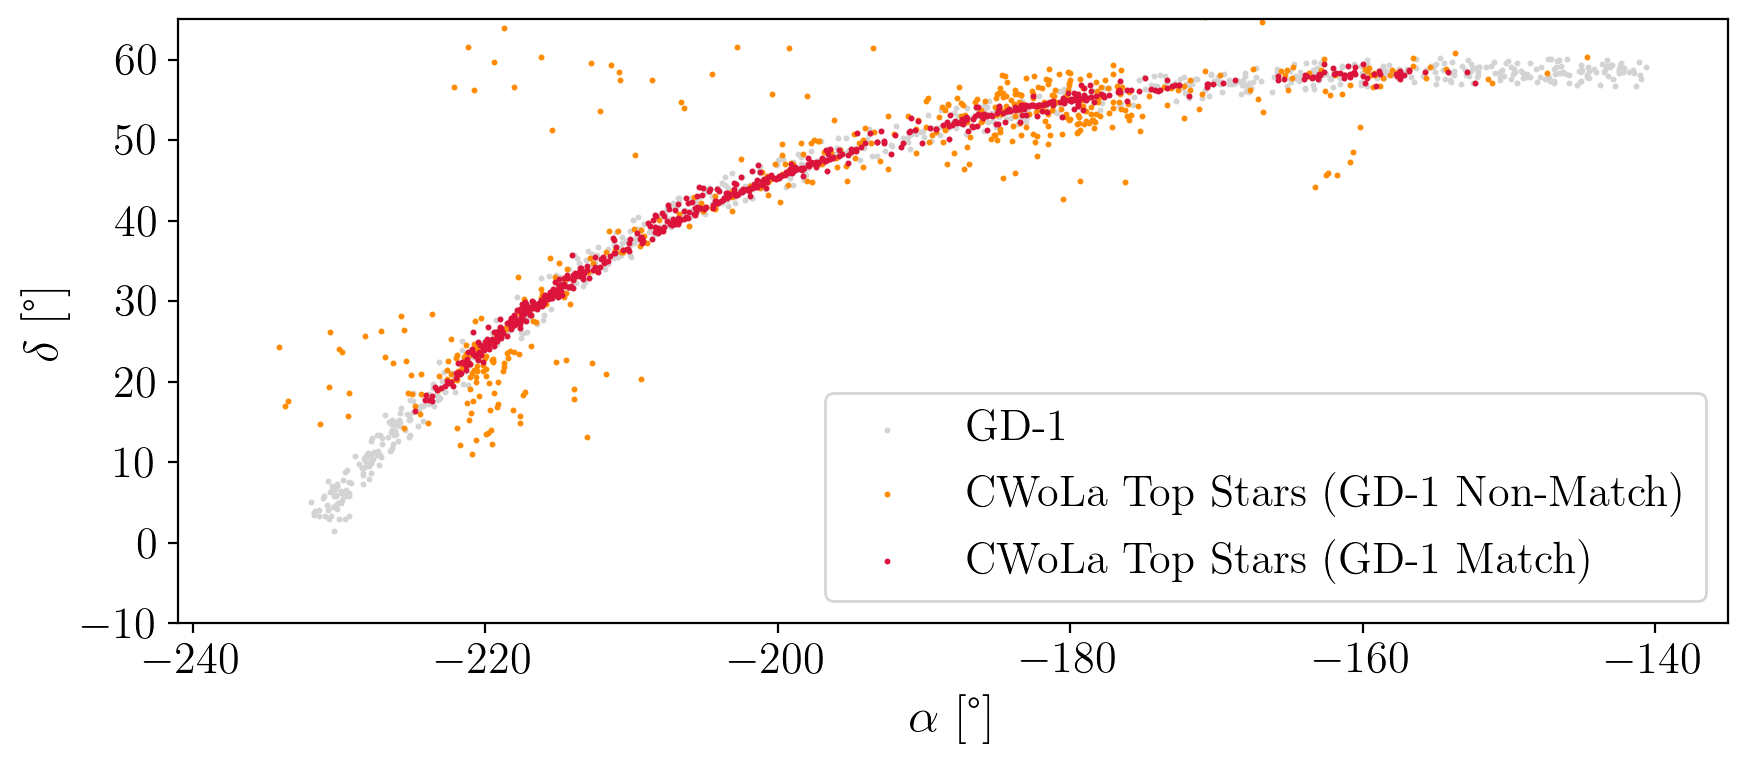

In [352]:
plt.figure(dpi=200, figsize=(10,4))
plt.scatter(all_gd1_stars.α_wrapped - 360, all_gd1_stars.δ, marker='.', s=markersize, 
            color="lightgray", label="GD-1")
plt.scatter(df[df.stream == False].α_wrapped - 360, df[df.stream == False].δ, marker='.', s=markersize, 
            color="darkorange", label="CWoLa Top Stars (GD-1 Non-Match)")
plt.scatter(df[df.stream].α_wrapped - 360, df[df.stream].δ, marker='.', s=markersize, 
            color="crimson", label="CWoLa Top Stars (GD-1 Match)")
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r"$\alpha$ [\textdegree]", fontsize=18);
plt.ylabel(r"$\delta$ [\textdegree]", fontsize=18);
# plt.xlim(120,220);
plt.xlim(-241,-135);
plt.ylim(-10,65);
# plt.savefig("via_machinae_aps_50patches_top50.pdf", bbox_inches="tight");

print("\n{:,} true GD-1 stars pass fiducial cuts.".format(all_gd1_stars.shape[0]))
print("{:,} stars identified by CWoLa, of which {:,} belong to GD-1.".format(df.shape[0], len(df[df.stream])))

print("\nPurity = {:.0f}% in top CWoLa-identified stars".format(100*len(df[df.stream])/len(df)))
print("Completeness = {:.0f}% vs. all of GD-1".format(100*len(df[df.stream])/len(all_gd1_stars)))

## Make rainbow plots

In [ ]:
# cwola_stars = cwola_stars[(cwola_stars.μ_α < 0) & (cwola_stars.μ_α > -12)]
# cwola_stars = cwola_stars[~((cwola_stars.μ_α > -5) & (cwola_stars.μ_δ > -6))] 

# print("\nPurity = {:.0f}% in top CWoLa-identified stars".format(100*len(cwola_stars[cwola_stars.stream])/len(cwola_stars)))
# print("Completeness = {:.0f}% vs. all of GD-1".format(100*len(cwola_stars[cwola_stars.stream])/len(all_gd1_stars)))     


Purity = 72% in top CWoLa-identified stars
Completeness = 38% vs. all of GD-1


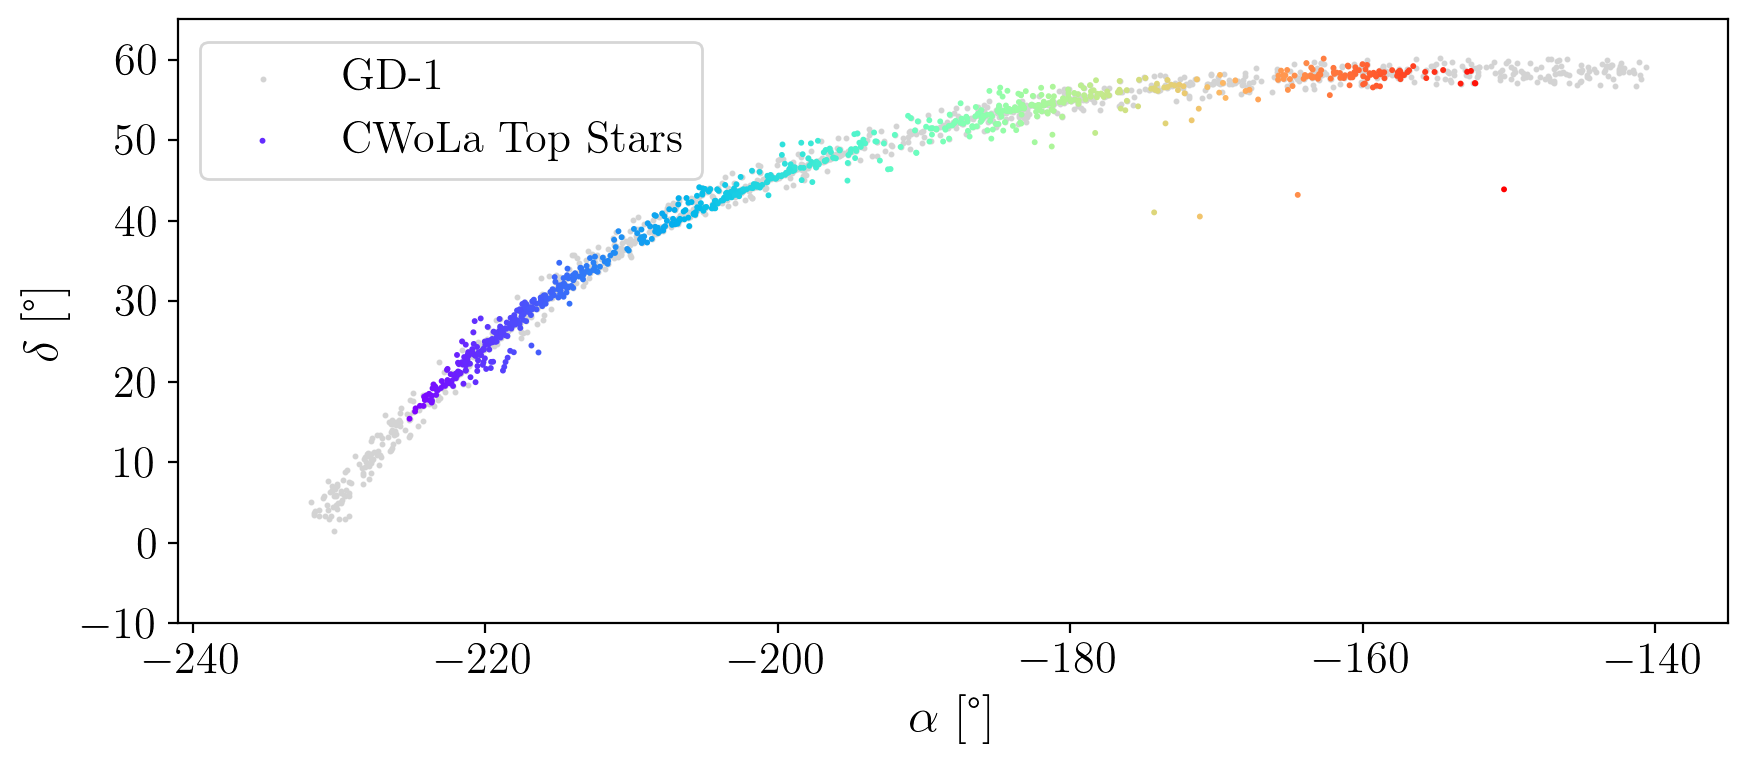

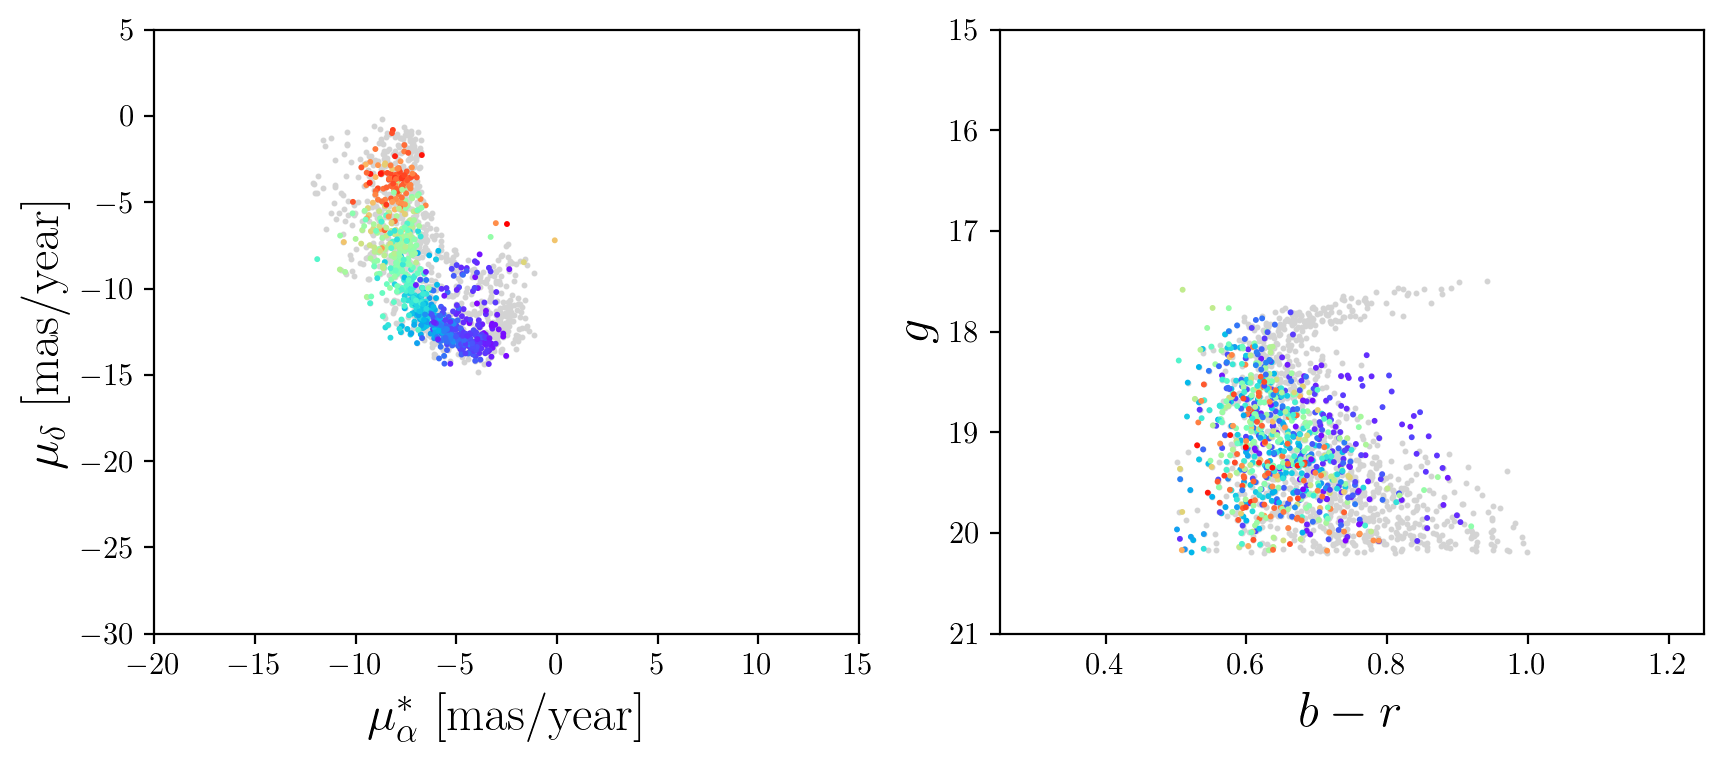

In [243]:
plt.figure(dpi=200, figsize=(10,4))
plt.scatter(all_gd1_stars.α_wrapped - 360, all_gd1_stars.δ, marker='.', s=markersize, 
            color="lightgray", label="GD-1")
plt.scatter(cwola_stars.α_wrapped - 360, cwola_stars.δ, marker='.', s=markersize, 
            c=cwola_stars.α_wrapped - 360, cmap='rainbow', label="CWoLa Top Stars")
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r"$\alpha$ [\textdegree]", fontsize=18);
plt.ylabel(r"$\delta$ [\textdegree]", fontsize=18);
plt.xlim(-241,-135);
plt.ylim(-10,65);

markersize = 5
fig, axs = plt.subplots(nrows=1, ncols=2, dpi=200, figsize=(10,4))

ax = axs[0]
ax.scatter(all_gd1_stars.μ_α, all_gd1_stars.μ_δ, marker='.', s=markersize, 
            color="lightgray", label="GD-1")
ax.scatter(cwola_stars.μ_α, cwola_stars.μ_δ, marker='.', s=markersize, 
            c=cwola_stars.α_wrapped - 360, cmap='rainbow', label="CWoLa Top Stars")
ax.set_xlabel(r"$\mu_\alpha^*$ [mas/year]", fontsize=18);
ax.set_ylabel(r"$\mu_\delta$ [mas/year]", fontsize=18);
ax.set_xlim(-20,15);
ax.set_ylim(-30,5);

ax = axs[1]
ax.scatter(all_gd1_stars['b-r'], all_gd1_stars.g, marker='.', s=markersize, 
            color="lightgray", label="GD-1")
ax.scatter(cwola_stars['b-r'], cwola_stars.g, marker='.', s=markersize, 
            c=cwola_stars.α_wrapped - 360, cmap='rainbow', label="CWoLa Top Stars")
ax.set_xlabel(r"$b-r$", fontsize=18);
ax.set_ylabel(r"$g$", fontsize=18);
ax.set_xlim(0.25,1.25);
ax.set_ylim(15,21);
ax.invert_yaxis()

# Rotate coordinates to stream-aligned $\phi_1$ and $\phi_2$

In [281]:
import astropy.units as u
from gala.coordinates import GD1Koposov10
from astropy.coordinates import SkyCoord

In [282]:
gd1_frame = GD1Koposov10()

### All GD-1 stars
coord_icrs = SkyCoord(ra=(all_gd1_stars['α_wrapped'] - 360)*u.degree, dec=all_gd1_stars.δ*u.degree, frame='icrs')
coord_gd1 = coord_icrs.transform_to(gd1_frame)
all_gd1_stars['ϕ1'] = coord_gd1.phi1.degree
all_gd1_stars['ϕ2'] = coord_gd1.phi2.degree

### CWoLa stars
coord_icrs = SkyCoord(ra=(cwola_stars['α_wrapped'] - 360)*u.degree, dec=cwola_stars.δ*u.degree, frame='icrs')
coord_gd1 = coord_icrs.transform_to(gd1_frame)
cwola_stars['ϕ1'] = coord_gd1.phi1.degree
cwola_stars['ϕ2'] = coord_gd1.phi2.degree

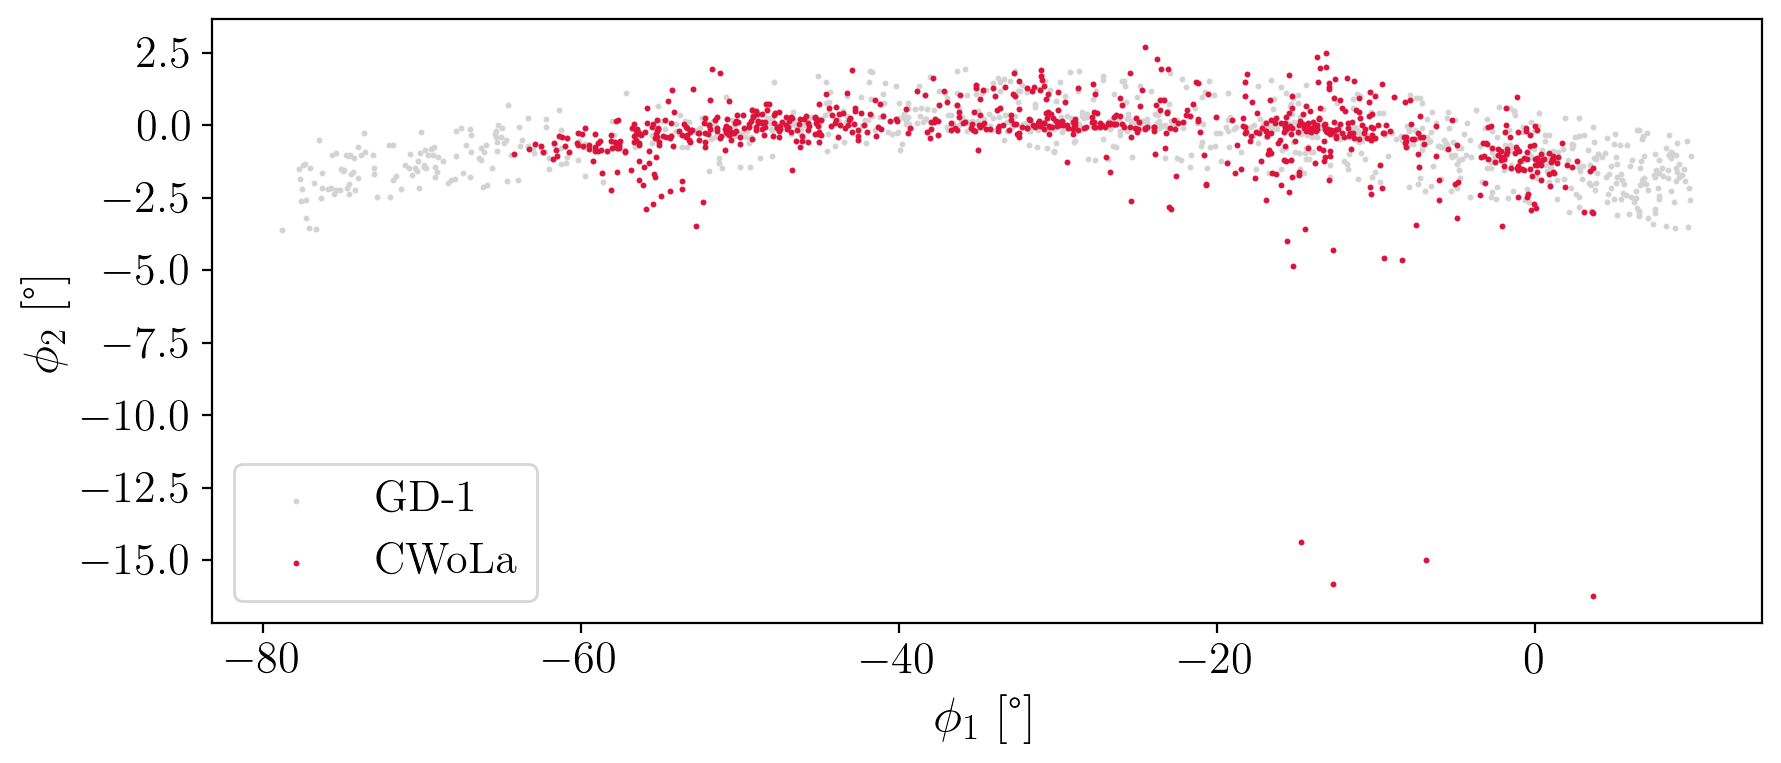

In [246]:
markersize = 5
plt.figure(dpi=200, figsize=(10,4))
plt.scatter(all_gd1_stars['ϕ1'], all_gd1_stars['ϕ2'], marker='.', s=markersize, color="lightgray", label="GD-1")
plt.scatter(cwola_stars['ϕ1'], cwola_stars['ϕ2'], marker='.', s=markersize, color="crimson", label="CWoLa")
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r"$\phi_1$ [\textdegree]", fontsize=18);
plt.ylabel(r"$\phi_2$ [\textdegree]", fontsize=18);

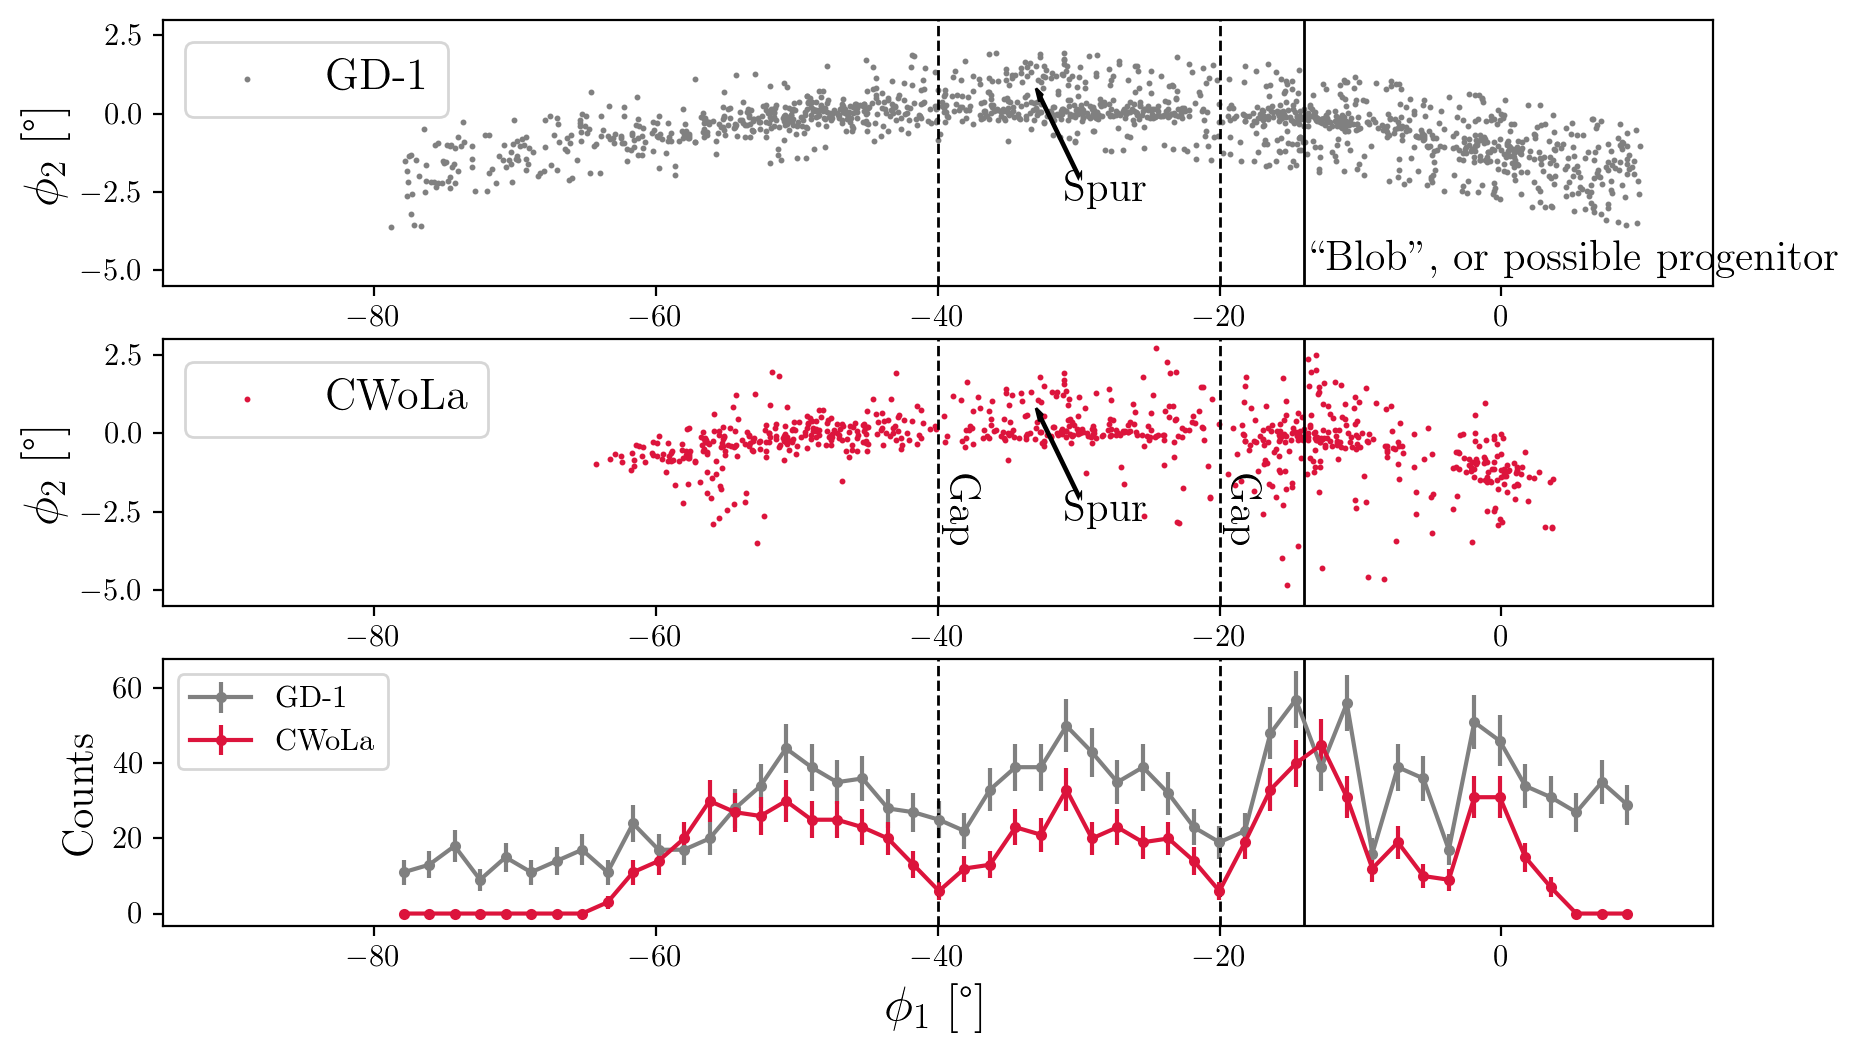

In [247]:
markersize = 5
fig, axs = plt.subplots(nrows=3, ncols=1, dpi=200, figsize=(10,6))

# gd1_stars = all_gd1_stars
gd1_stars = all_gd1_stars[(all_gd1_stars.g < 20.2) & (0.5 < all_gd1_stars['b-r']) & (all_gd1_stars['b-r'] < 1)]

ax = axs[0]
ax.scatter(gd1_stars['ϕ1'], gd1_stars['ϕ2'], marker='.', s=markersize, color="gray", label="GD-1")
ax.legend(fontsize=16)
ax.set_xlabel(r"$\phi_1$ [\textdegree]", fontsize=18);
ax.set_ylabel(r"$\phi_2$ [\textdegree]", fontsize=18);
ax.axvline(-40,c='k',linestyle='dashed',lw=1)
ax.axvline(-20,c='k',linestyle='dashed',lw=1)
ax.axvline(-14,c='k',lw=1)
ax.arrow(-30,-2,-2.7,2.5,width=0.1,color='k')
ax.text(-31,-2.8,'Spur')
ax.set_ylim(-5.5,3)
ax.set_xlim(-95,15)
ax.text(-14+0.5,-5,'``Blob", or possible progenitor',rotation=0)

ax = axs[1]
ax.scatter(cwola_stars['ϕ1'], cwola_stars['ϕ2'], marker='.', s=markersize, color="crimson", label="CWoLa")
ax.legend(fontsize=16)
ax.set_xlabel(r"$\phi_1$ [\textdegree]", fontsize=18);
ax.set_ylabel(r"$\phi_2$ [\textdegree]", fontsize=18);
ax.set_ylim(-5.5,3)
ax.set_xlim(-95,15)
ax.text(-40+0.2,-3.4,'Gap',rotation=-90)
ax.axvline(-40,c='k',linestyle="dashed",lw=1)
ax.arrow(-30,-2,-2.7,2.5,width=0.1,color='k')
ax.text(-31,-2.8,'Spur')
ax.axvline(-14,c='k',lw=1)
ax.text(-20+0.2,-3.4,'Gap',rotation=-90)
ax.axvline(-20,c='k',linestyle="dashed",lw=1)

ax = axs[2]
ax.set_xlabel(r"$\phi_1$ [\textdegree]", fontsize=18);
ax.set_xlim(-95,15);

bins = np.linspace(np.min(gd1_stars['ϕ1']),np.max(gd1_stars['ϕ1']),50)
counts_gd1, _   = np.histogram(gd1_stars['ϕ1'], bins=bins) 
counts_cwola, _ = np.histogram(cwola_stars['ϕ1'], bins=bins) 
ax.errorbar(0.5*(bins[1:]+bins[:-1]),counts_gd1, yerr=np.sqrt(counts_gd1),  marker='.',c='gray', label='GD-1')
ax.errorbar(0.5*(bins[1:]+bins[:-1]),counts_cwola, yerr=np.sqrt(counts_cwola), marker='.', c='crimson', label='CWoLa')
ax.legend(loc='upper left');
ax.axvline(-14,c='k',lw=1)
ax.axvline(-20,c='k',linestyle="dashed",lw=1)
ax.axvline(-40,c='k',linestyle="dashed",lw=1)
ax.set_ylabel('Counts');
# ax.set_ylim(0,80);
# plt.savefig("phi1_phi2_brg_cuts.pdf")

# Add promising stars

In [ ]:
labeled = cwola_stars[cwola_stars.stream]
unlabeled = cwola_stars[cwola_stars.stream == False]

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(12,4), dpi=300, tight_layout=True)

ax = axs[0]
ax.set_title("Stellar Positions")
ax.scatter(all_gd1_stars.α, all_gd1_stars.δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.α, labeled.δ, marker='.', color="crimson",label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(unlabeled.α, unlabeled.δ, marker='.', color="dodgerblue", label="Unlabeled (Top {})".format(n_top_stars))
# ax.set_xlim(-15,15)
# ax.set_ylim(-15,15)
ax.legend()
ax.set_xlabel(r"$\alpha$[\textdegree]")
ax.set_ylabel(r"$\delta$[\textdegree]");

ax = axs[1]
ax.set_title("Stellar Velocities")
ax.scatter(all_gd1_stars.μ_α, all_gd1_stars.μ_δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.μ_α, labeled.μ_δ, marker='.', color="crimson", label="CWoLa Top {} (Labeled)".format(n_top_stars))
ax.scatter(unlabeled.μ_α, unlabeled.μ_δ, marker='.', color="dodgerblue", label="CWoLa Top {} (Unlabeled)".format(n_top_stars))
# ax.set_xlim(-15,15)
# ax.set_ylim(-15,15)
ax.set_xlabel(r"$\mu_{\alpha}$")
ax.set_ylabel(r"$\mu_{\delta}$");

ax = axs[2]
ax.set_title("Magnitude vs. Color")
ax.scatter(all_gd1_stars.color, all_gd1_stars.mag, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.color, labeled.mag, marker='.', color="crimson", label="CWoLa Top {} (Labeled)".format(n_top_stars))
ax.scatter(unlabeled.color, unlabeled.mag, marker='.', color="dodgerblue", label="CWoLa Top {} (Unlabeled)".format(n_top_stars))
ax.set_xlabel(r"Color")
ax.set_ylabel(r"Magnitude");
# plt.savefig("../plots/mislabeled_triptych.png")

Identify promising unlabeled stars...

In [ ]:
from scipy.spatial import distance_matrix
cols = ["μ_α", "δ", "α", "color", "mag"]
dists = distance_matrix(labeled[cols].to_numpy(), unlabeled[cols].to_numpy())
closest_labeled = labeled.iloc[dists.argmin(axis=0)]
deltas = unlabeled[cols].to_numpy()-closest_labeled[cols].to_numpy()
distances = np.sqrt(np.sum(deltas**2, axis=1))
unlabeled['5d_distance'] = distances

plt.figure(dpi=300)
plt.hist(unlabeled["5d_distance"], bins=60)
plt.title("5D Distances: Unlabeled to Closest Labeled Star");
plt.ylabel("Counts")
plt.xlabel("5D Euclidean Distance");
# plt.savefig("../plots/5d_distance.png")

In [ ]:
# promising = unlabeled[(unlabeled['5d_distance'] < 1)] # restrict by a specific distance
promising = unlabeled[(unlabeled['5d_distance'] < unlabeled['5d_distance'].quantile(0.1))] # restrict to the top x%

In [ ]:
len(promising)

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(12,4), dpi=300, tight_layout=True)

ax = axs[0]
ax.set_title("Stellar Positions")
ax.scatter(all_gd1_stars.α, all_gd1_stars.δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.α, labeled.δ, marker='.', color="crimson",label="Labeled GD1 (Top {})".format(n_top_stars))
ax.scatter(promising.α, promising.δ, marker='.', color="dodgerblue", label="promising (Top {})".format(n_top_stars))
# ax.set_xlim(-15,15)
# ax.set_ylim(-15,15)
ax.legend()
ax.set_xlabel(r"$\alpha$[\textdegree]")
ax.set_ylabel(r"$\delta$[\textdegree]");

ax = axs[1]
ax.set_title("Stellar Velocities")
ax.scatter(all_gd1_stars.μ_α, all_gd1_stars.μ_δ, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.μ_α, labeled.μ_δ, marker='.', color="crimson", label="CWoLa Top {} (Labeled)".format(n_top_stars))
ax.scatter(promising.μ_α, promising.μ_δ, marker='.', color="dodgerblue", label="CWoLa Top {} (promising)".format(n_top_stars))
# ax.set_xlim(-15,15)
# ax.set_ylim(-15,15)
ax.set_xlabel(r"$\mu_{\alpha}$")
ax.set_ylabel(r"$\mu_{\delta}$");

ax = axs[2]
ax.set_title("Magnitude vs. Color")
ax.scatter(all_gd1_stars.color, all_gd1_stars.mag, color = "lightgray", marker='.', label="All Labeled GD1 in Test Set")
ax.scatter(labeled.color, labeled.mag, marker='.', color="crimson", label="CWoLa Top {} (Labeled)".format(n_top_stars))
ax.scatter(promising.color, promising.mag, marker='.', color="dodgerblue", label="CWoLa Top {} (promising)".format(n_top_stars))
ax.set_xlabel(r"Color")
ax.set_ylabel(r"Magnitude");
# plt.savefig("../plots/mislabeled_triptych.png")

In [ ]:
plt.figure(dpi=200, figsize=(12,4))
plt.scatter(all_gd1_stars.α, all_gd1_stars.δ, marker='.', s=10, 
            color="lightgray", label="GD1")
plt.scatter(promising.α, promising.δ, marker='.', s=10, 
            color="dodgerblue", label="CWoLa (Promising Candidates)")
plt.scatter(cwola_stars[cwola_stars.stream].α, cwola_stars[cwola_stars.stream].δ, marker='.', s=10, 
            color="crimson", label="CWoLa (Match)")
plt.legend(fontsize=13)
plt.xlabel(r"$\alpha$ [\textdegree]");
plt.ylabel(r"$\delta$ [\textdegree]");
plt.xlim(120,220);
# plt.savefig("via_machinae_aps_50patches_top50.png");